In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Wed Jun  2 03:27:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Data/Age_Gender/DataBase

/content/drive/MyDrive/Colab Notebooks/Data/Age_Gender/DataBase


# **Library**

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Constant

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/Data/Age_Gender/DataBase"
TRAIN_TEST_SPLIT = 0.9
IM_WIDTH = IM_HEIGHT = 224
ID_GENDER_MAP = {0: 'Male', 1: 'Female'}

# *DataFrame*

In [ ]:
import pandas as pd

path = DATA_DIR

dirs = os.listdir(path)
records = []
for files in dirs:
  if files.endswith(".jpg"):
    file_name = path + "/" + files
    try:
      age, gender, _, _ = files.split('_')
      if int(age) <= 100:
        records.append([int(age), int(gender), ID_GENDER_MAP[int(gender)], file_name])
    except:
      continue

df = pd.DataFrame(records)
df.columns = ['age', 'gender', 'gender_id', 'path_file']
df = df.dropna()

In [ ]:
df

,age,gender,gender_id,path_file
0,36,1,Female,/content/drive/MyDrive/Colab Notebooks/Data/Ag...
1,36,1,Female,/content/drive/MyDrive/Colab Notebooks/Data/Ag...
2,36,1,Female,/content/drive/MyDrive/Colab Notebooks/Data/Ag...
3,36,1,Female,/content/drive/MyDrive/Colab Notebooks/Data/Ag...
4,36,1,Female,/content/drive/MyDrive/Colab Notebooks/Data/Ag...
...,...,...,...,...
24073,51,0,Male,/content/drive/MyDrive/Colab Notebooks/Data/Ag...
24074,63,0,Male,/content/drive/MyDrive/Colab Notebooks/Data/Ag...
24075,68,0,Male,/content/drive/MyDrive/Colab Notebooks/Data/Ag...
24076,70,0,Male,/content/drive/MyDrive/Colab Notebooks/Data/Ag...


#**DATA ANALYSIS**

In [ ]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

In [ ]:
import plotly.express as px

fig = px.histogram(df, x="gender_id")
fig.update_layout(title_text='Gender distribution')
fig.show()

#**Data PreProcessing**

In [ ]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx, test_idx = p[:train_up_to], p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

max_age = df['age'].max()

In [ ]:
print("Data training: " + str(len(train_idx)) + " photos")
print("Data validation: " + str(len(valid_idx)) + " photos")
print("Data test: " + str(len(test_idx)) + " photos")

Data training: 19503 photos
Data validation: 2167 photos
Data test: 2408 photos


In [ ]:
from tensorflow.keras.utils import to_categorical
import cv2
from PIL import Image

def get_data_generator(df, indices, batch_size=16):
    images, ages, genders = [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            path_file, age, gender = r['path_file'], r['age'], r['gender']
            im = cv2.imread(path_file, cv2.IMREAD_COLOR)
            im = cv2.resize(im, (IM_WIDTH, IM_HEIGHT))
            im = np.array(im, dtype=np.float32) / 255.0
            images.append(im)
            ages.append(age/max_age)
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders)]
                images, ages, genders = [], [], []

In [ ]:
batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, batch_size=valid_batch_size)

#**Build Model**

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, Flatten

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)
 
# for age calculation
x = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(x)

# for gender prediction
x = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=2, activation='softmax', name='gender_output')(x)
 
model = Model(inputs=input_layer, outputs=[age_output, gender_output])

model.compile(optimizer='rmsprop',
              loss={'age_output': 'mse', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 4., 'gender_output': 1.},
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 220, 220, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

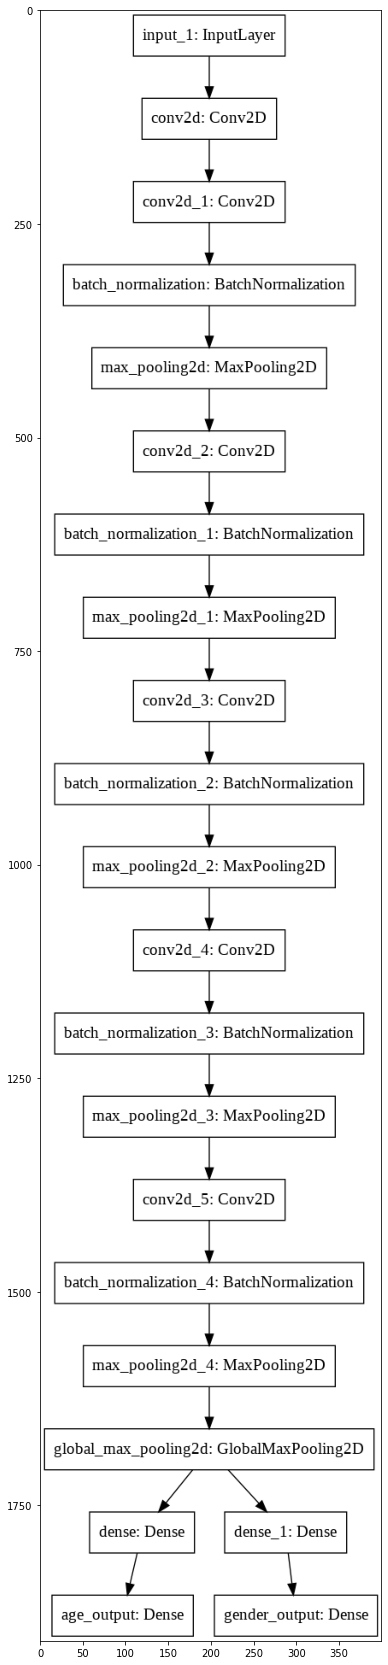

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png')
img = mpimg.imread('model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

#**Model Training**

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/checkpoint_dir

/content/drive/MyDrive/Colab Notebooks/checkpoint_dir


In [ ]:
from keras.callbacks import ModelCheckpoint

if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/checkpoint_dir/checkpoint'):
	os.mkdir('/content/drive/MyDrive/Colab Notebooks/checkpoint_dir/checkpoint')


cp_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/checkpoint_dir/checkpoint', 
    verbose=1, 
    save_weights_only=False,
    save_freq=60)

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=20,
                    callbacks=[cp_callback],
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/20
 60/304 [====>.........................] - ETA: 1:42:11 - loss: 2.1120 - age_output_loss: 0.1281 - gender_output_loss: 1.5994 - age_output_mae: 0.2984 - gender_output_accuracy: 0.5559
Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/checkpoint_dir/checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/checkpoint_dir/checkpoint/assets
120/304 [==========>...................] - ETA: 1:17:03 - loss: 1.7103 - age_output_loss: 0.1121 - gender_output_loss: 1.2619 - age_output_mae: 0.2741 - gender_output_accuracy: 0.5815
Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/checkpoint_dir/checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/checkpoint_dir/checkpoint/assets
180/304 [================>.............] - ETA: 52:02 - loss: 1.5166 - age_output_loss: 0.1009 - gender_output_loss: 1.1131 - age_output_mae: 0.2565 - gender_output_accuracy: 0.5950
Epoch 00001: saving model to /content

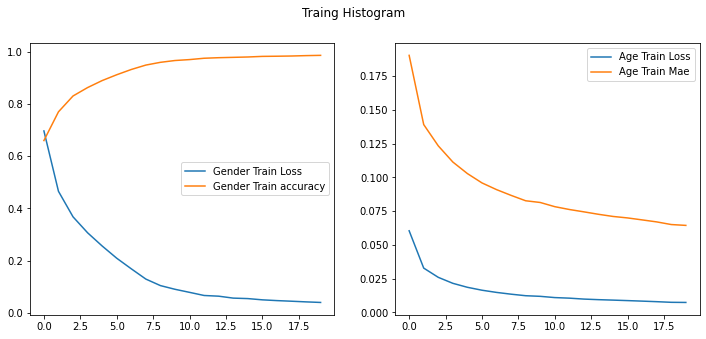

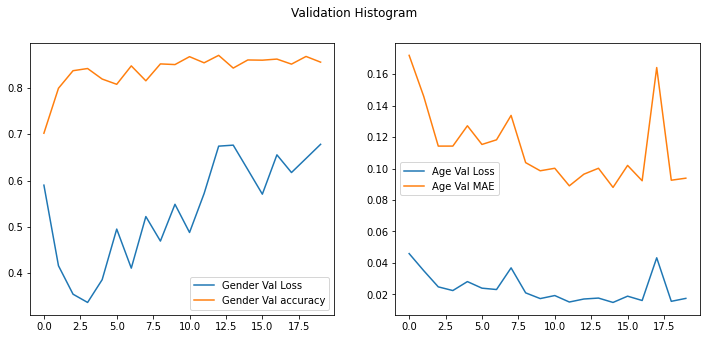

In [ ]:
def  plot_train_history(history):

    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Traing Histogram")
    plt.subplot(1, 2, 1)
    plt.plot(history.history['gender_output_loss'], label='Gender Train Loss')
    plt.plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    # plt.set_xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['age_output_loss'], label='Age Train Loss')
    plt.plot(history.history['age_output_mae'], label='Age Train Mae')
    # plt.set_xlabel('Epochs')
    plt.legend()  

    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Validation Histogram")

    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_gender_output_loss'], label='Gender Val Loss')
    plt.plot(history.history['val_gender_output_accuracy'], label='Gender Val accuracy')
    # plt.set_xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_age_output_loss'], label='Age Val Loss')
    plt.plot(history.history['val_age_output_mae'], label='Age Val MAE')
    # plt.set_xlabel('Epochs')
    plt.legend()  

plot_train_history(history)

#**Save Model**

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
model.save('age_gender.h5')

#**Load Model**

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('age_gender.h5')

#**Test Model**

In [ ]:
test_gen = get_data_generator(df, test_idx, batch_size=128)
x_test, [age_true, gender_true] = next(test_gen)
age_pred, gender_pred = model.predict_on_batch(x_test)

In [ ]:
gender_true = gender_true.argmax(axis=-1)
gender_pred = gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [ ]:
from __future__ import print_function
import numpy as np 

def age_acc(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
      if abs(y_true[i] - y_pred[i]) <= 10:
        correct += 1
    return correct/y_true.shape[0]

def gender_acc(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct/y_true.shape[0]

print('Age accuracy = ', age_acc(age_true, age_pred))
print('Gender accuracy = ', gender_acc(gender_true, gender_pred))

Age accuracy =  0.703125
Gender accuracy =  0.796875


[]

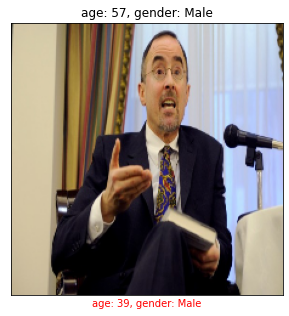

In [ ]:
img_idx = 4
age_threshold = 10

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(x_test[img_idx][:,:,::-1])
ax.set_title('age: {}, gender: {}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]]))
if abs(int(age_pred[img_idx]) - int(age_true[img_idx])) <= age_threshold and gender_pred[img_idx] == gender_true[img_idx]:
  ax.set_xlabel('age: {}, gender: {}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]]), color='green')
else:
  ax.set_xlabel('age: {}, gender: {}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]]), color='red')
ax.set_xticks([])
ax.set_yticks([])

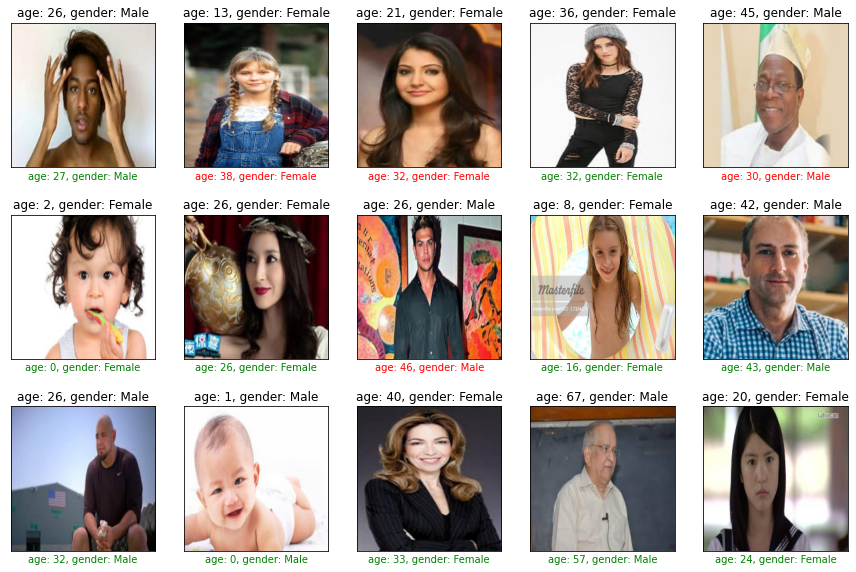

In [ ]:
import math
n = 15
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

age_threshold = 10

for i, img_idx in enumerate(random_indices+100):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx][:,:,::-1])
    ax.set_title('age: {}, gender: {}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]]))
    if abs(int(age_pred[img_idx]) - int(age_true[img_idx])) <= age_threshold and gender_pred[img_idx] == gender_true[img_idx]:
      ax.set_xlabel('age: {}, gender: {}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]]), color='green')
    else:
      ax.set_xlabel('age: {}, gender: {}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]]), color='red')
    ax.set_xticks([])
    ax.set_yticks([])